# Домашнее задание №3 - Линейная регрессия для предсказания продолжительности жизни

В этой части домашки вам нужно сделать вашу первую полноценную **модель машинного обучения**!

Для этого мы возьмем датасет по **продолжительности жизни** и попробуем построить по нему **линейную регрессию**. Будем стараться выделить наиболее **важные для продолжительности жизни признаки**, а также постараемся сделать нашу модель **устойчивой** к новым данным - то есть избежать **переобучения**.

Описание датасета можно найти [тут](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Часть 1. EDA (15 баллов)

Загрузите датасет `Life Expectancy Data.csv`

Как и всегда, для начала вам нужно провести небольшое **EDA** ваших данных, убедиться в том, что в них нет **пропущенных значений** или еще каких-то **бед**.

Советуем **убрать** из рассмотрения **категориальные переменные**, чтобы они вас не смущали.

Помимо этого, обратите внимание на **стандартизацию** ваших данных. Но с этим **не торопитесь**. Сделайте EDA и посмотрите, что будет, когда мы проведём разбиение данных на тестовую и тренировочную выборки.

In [5]:
# YOUR CODE HERE
df = pd.read_csv("../data/Life Expectancy Data.csv")

In [6]:
df.shape

(2938, 22)

In [7]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [8]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [9]:
# Удаление лишних пробелов в названиях столбцов
df.columns = df.columns.str.strip()

# Удаление категориальных переменных
df_numeric = df.drop(columns=['Country', 'Status'])

In [10]:
column_nan_count = df_numeric.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

NaN count per column:
Year                                 0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64


In [11]:
# Пропусков слишком много чтобы их просто удалить. Т.к. в колонке Year нет пропусков можно попробовать сгруппировать пропуски по каждому году и заполнить их медианными занчениямим
df_full = df_numeric.copy()
for column in df_full.columns[1:]:  # Пропускаем первый столбец 'Year'
    df_full[column] = df_full.groupby('Year')[column].transform(lambda x: x.fillna(x.median()))

In [12]:
print(f'Количество пропусков: {df_full.isnull().sum().sum()}')

Количество пропусков: 0


In [13]:
df_full.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.238462,164.695031,30.303948,4.637600,738.251295,82.644656,2419.592240,38.386555,42.035739,82.605344,6.005061,82.374575,1.742103,6657.444137,1.024153e+07,4.822362,4.852689,0.630526,12.013513
std,4.613841,9.510459,124.092441,117.926501,3.921306,1987.914858,22.881890,11467.272489,19.939693,160.445548,23.362728,2.416410,23.649290,5.077785,13284.996285,5.402084e+07,4.397466,4.485674,0.205378,3.267787
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.200000,74.000000,0.000000,1.082500,4.685343,82.000000,0.000000,19.400000,0.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.100000,144.000000,3.000000,4.100000,64.912906,91.000000,17.000000,43.450000,4.000000,93.000000,5.895000,93.000000,0.100000,1791.067713,1.412669e+06,3.300000,3.300000,0.681000,12.300000
75%,2012.000000,75.600000,227.000000,22.000000,7.390000,441.534144,96.000000,360.250000,56.100000,28.000000,97.000000,7.330000,97.000000,0.800000,4779.405190,4.584371e+06,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


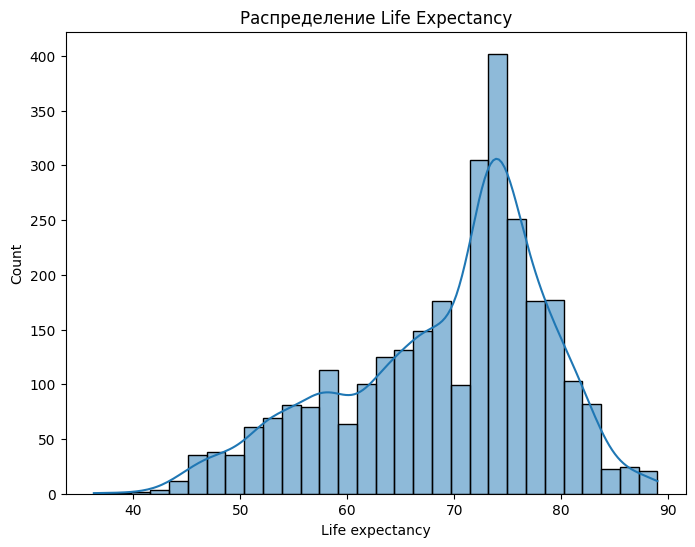

In [14]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(8, 6))
sns.histplot(df_full["Life expectancy"], bins=30, kde=True)
plt.title("Распределение Life Expectancy")
plt.show()

In [15]:
correlation_matrix = df_full.corr()

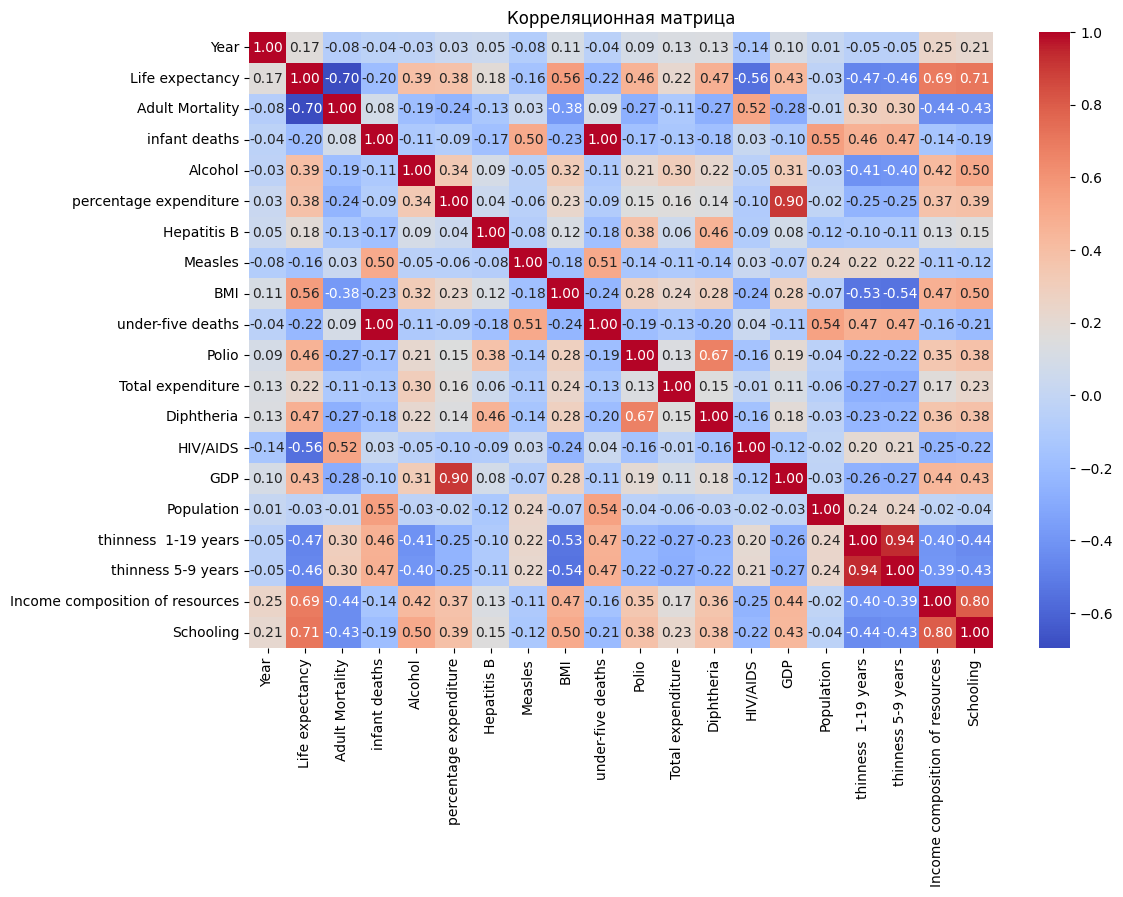

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

Найдите что из этого **фичи**, что из этого **таргет** и положите соответствующие данные в X (фичи) и y (таргетная переменная).

In [17]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df_full.drop(columns=["Life expectancy"])
y = df_full["Life expectancy"]

После всего этого вам нужно будет разбить датасет на **тренировочную и тестовую выборки**. 

Тестовая выборка понадобится нам для того, чтобы оценить, насколько наша модель переобучилась. Для этого используйте функцию [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Не забудьте установить какое-то значение в `random_seed` для воспроизводимости. И определите соотношение train/test в процентах через параметр `test_size`

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

И вот только теперь **время для стандартизации** ваших данных и вот почему.

Вы уже знаете, что перед тем как положить **ваши данные** в модель их нужно привести к более менее одной и той же шкале, то есть **стандартизовать**. Для этого можно использовать уже наш любимый `StandardScaler`. У него есть `fit`, и есть `transform`. Но его **нельзя использовать на всём** нашем датасете!

Дело в том, что при работе с моделями машинного обучения мы очень **боимся раньше времени "показать" данные тренировочной выборки** моделе, aka *Data linkage* или утечка данных. Представьте, что у вас есть класс учеников, которые кое-как подглядели ответы на контрольную, а вам нужно оценить **реальные знания**. Но ведь так будет нечестно. Вы потом скажете завучу, что ребята хорошо знают материал, умеют обобщать и справляться с разными вариациями стандартных задач, но ведь это неправда. 

Когда вы фитите скейлер на **всём датасете**, вы вычисляете среднее и дисперсию по **всем-всем данным**, и по трейну и по тесту, а значит неизбежно **даёте моделе подглядеть** ваш тест, который мы так бережно хотим спрятать. Поэтому вот как вам обычно нужно действовать:
* загрузили датасет
* сделали EDA, выбрали фичи и всё такое
* разбили на трейн и тест
* зафитили скейлер **только на трейне**
* трансофрмировали данные трейна
* трансформировали данные теста

Попробуйте ниже!

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)  # Трансформируем тренировочные данные
X_test_scaled = scaler.transform(X_test)  # Трансформируем тестовые данные

## Часть 2. Создание и сравнение моделей (35 баллов)

Создайте две модели - обычную **линейную регрессию** и **ElasticNet**. 

In [20]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
# Предсказания на обучающем и тестовом наборах
y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)

In [21]:
# Обучение модели ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train_scaled, y_train)
# Предсказания на обучающем и тестовом наборах
y_train_pred_en = elastic_net.predict(X_train_scaled)
y_test_pred_en = elastic_net.predict(X_test_scaled)

Проанализируйте значения метрик **MSE, RMSE, MAE, R-squared, adjusted R-squared** для полученных моделей на тренировочном датасете. Сделайте вывод о лучшей модели. 

Залезьте в документацию и обратите внимание на **порядок**, в котором нужно передавать переменные в функции. Есть разница между тем, чтобы первой сообщать настоящие значения y, а потом предсказанные и наоборот.

In [22]:
# Функция для вычисления и оценки метрик качества моделей
def evaluate_model(y_true, y_pred, model_name, train_test_data):
    mse = mean_squared_error(y_true, y_pred)  # Среднеквадратичная ошибка
    rmse = mse ** 0.5  # Корень среднеквадратичной ошибки
    mae = mean_absolute_error(y_true, y_pred)  # Средняя абсолютная ошибка
    r_squared = r2_score(y_true, y_pred)  # R2 (коэффициент детерминации)
    adjusted_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - X_train.shape[1] - 1) # Скорректированное R2 учитывает количество признаков в модели
    
    # Вывод метрик
    print(f'Metrics results for {model_name} model on {train_test_data} data')
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r_squared:.2f}")
    print(f"Adjusted R2: {adjusted_r_squared:.2f}\n")

*И не забывайте про вторую модель*

In [23]:
evaluate_model(y_train, y_train_pred_lr, "Linear Regression", "Training")
evaluate_model(y_train, y_train_pred_en, "ElasticNet", "Training")

Metrics results for Linear Regression model on Training data
MSE: 16.76
RMSE: 4.09
MAE: 3.04
R2: 0.82
Adjusted R2: 0.82

Metrics results for ElasticNet model on Training data
MSE: 17.56
RMSE: 4.19
MAE: 3.12
R2: 0.81
Adjusted R2: 0.81



Среди представленных выше моделей наиболее точной является простая линейная регрессия. Её показатели метрик MSE, RMSE и MAE ниже, чем у ElasticNet, что свидетельстувет о том, что модель линейной регресии имеет меньшую погрешность предсказания. Также факт того, что значение R2 у линейной регрессии выше чем у ElasticNet указывает на то, что модель линейно регресии точнее в данной ситуации. Примение для этих данных более сложной модели ElasticNet может быть избыточным.

Для обеих моделей можно получить **вектор значений весов** при переменных. Эти веса указывают на вклад переменной в регрессию. Какие переменные наиболее важны для предсказания *life expectancy* по мнению обеих моделей?

In [24]:
print("Linerar regression coefficents:")
print(pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False))

Linerar regression coefficents:
under-five deaths                 -10.903805
infant deaths                      10.737199
Adult Mortality                    -2.649308
HIV/AIDS                           -2.437510
Schooling                           2.127248
Income composition of resources     1.323244
Diphtheria                          0.985510
BMI                                 0.796384
Polio                               0.635422
GDP                                 0.594683
Alcohol                             0.448355
thinness  1-19 years               -0.423130
Hepatitis B                        -0.413635
Measles                            -0.289408
Total expenditure                   0.167030
percentage expenditure              0.161363
Year                               -0.093192
Population                         -0.056482
thinness 5-9 years                  0.037685
dtype: float64


In [25]:
print("ElasticNet coefficients:")
print(pd.Series(elastic_net.coef_, index=X.columns).sort_values(key=abs, ascending=False))

ElasticNet coefficients:
Adult Mortality                   -2.609950
HIV/AIDS                          -2.366135
Schooling                          2.043174
Income composition of resources    1.505451
Diphtheria                         1.028234
BMI                                0.834549
Polio                              0.699446
GDP                                0.452087
Measles                           -0.357102
Hepatitis B                       -0.326484
Alcohol                            0.322637
thinness  1-19 years              -0.302420
percentage expenditure             0.252953
under-five deaths                 -0.159731
Total expenditure                  0.136490
Population                         0.070357
thinness 5-9 years                -0.048482
Year                              -0.002380
infant deaths                      0.000000
dtype: float64


In [26]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [27]:
correlation = df_full['infant deaths'].corr(df['under-five deaths'])
correlation

0.996628882039803

Переменные under-five deaths и infant deaths вносят наибольший вклад в предсказательную способность модели линейной регрессии. Таким образом смертность младенцев и детей возраста до 5 лет является значительно важным фактором для параметра - продолжительность жизни. Помимо этого важными для целевой переменной факторами являются переменные Adult Mortality и HIV/AIDS. Можно сделать вывод, что уровень смертности совершеннолетних и наличие у человека ВИЧ-инфекции также отрицательно влияют на значение ожидаемой продолжительности жизни. К параметрам, которые положительно влияют на Life Expectancy факторов можно отнести Schooling и Income composition of resources. Следовательно,  образование и экономическое благосостояние важно для увеличения продолжительности жизни.  
В целом в модели ElasticNet присутствует схожее распределение сначимости коэффициентов, за некоторыми исключениями. Например, наиболее значимым параметрами с отрицательным значением являются Adult Mortality и HIV/AIDS, в то время как  under-five deaths оказывает сильно меньшее влияние на целевую переменную. Переменная infant deaths в списке коффициентов отсутствует. Возможно это связано с тем, что ElasticNet удалил переменную в связи с высокой корреляцией с переменной  infant deaths. Переменные  Schooling и Income composition of resources также оказываеют положительное влияние на ожидаемую продолжительность жизни.  
В заключение, обе модели определили, что на значение ожидаемой продолжительности жизни главным образом влияют:  уровень смертности среди взрослых и детей, уровнень образования, экономического развития и заболеваемости ВИЧ. Но модель может быть меньше подвержена переобучению за счет удаления из расчетов переменных, переменных, хорошо коррелирующих друг с другом (имеется в виду удаление одной переменной из двух в случае высокой корреляции между ними)

Теперь нам нужно **оценить, не переобучаются ли наши модели**. Для этого вспомним о тестовой выборке и получим значения метрик для нее.

In [28]:
evaluate_model(y_test, y_test_pred_lr, "Linear Regression", "Test")
evaluate_model(y_test, y_test_pred_en, "ElasticNet", "Test")

Metrics results for Linear Regression model on Test data
MSE: 15.47
RMSE: 3.93
MAE: 2.85
R2: 0.82
Adjusted R2: 0.82

Metrics results for ElasticNet model on Test data
MSE: 16.54
RMSE: 4.07
MAE: 2.94
R2: 0.81
Adjusted R2: 0.80



Значения метрик для обучающей и тестовой выборок у модели линейной регрессии довольно близки. Значения у MSE, RMSE и MAE на тестовой выборке немного ниже, чем на тренировочной выборке, что является очень хорошим результатом в плане точности модели на незнакомых данных. Коэффициент детерминации остается на уровне 0.82 у обоих моделей. Таким образом, можно сделать вывод, что линейная регрессия не переобучается и сможет точно предсказывать значение целевой переменной на новых данных.
В случае модели ElasticNet такая же ситуация. Значения у MSE, RMSE и MAE на тестовой выборке немного ниже, чем на тренировочной выборке, а значения R2 почти не отличаются (разница 0.01). Значения метрик ошибок немного выше у ElasticNet, возможно за счет большей строгости модели при обучении и стремлении предотвратить переобучение.

**(доп задание: 15 баллов)** А теперь мы предлагаем вам немного поиграть **с соотношением тестовой и тренировочной выборки**. Как мы уже говорили на лекции обычно берётся 80% данных в тест и 20% в трейн. Попробуйте сделать **наоборот** и посмотреть что получится. Не забудьте описать ваши наблюдения.

In [29]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, 
                                                    test_size=0.8,
                                                    random_state=42)
scaler = StandardScaler()
scaler.fit(X_train2)

X_train_scaled = scaler.transform(X_train2)  # Трансформируем тренировочные данные
X_test_scaled = scaler.transform(X_test2)  # Трансформируем тестовые данные
lr = LinearRegression()
lr.fit(X_train_scaled, y_train2)
# Предсказания на обучающем и тестовом наборах
y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)
# Обучение модели ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train_scaled, y_train2)
# Предсказания на обучающем и тестовом наборах
y_train_pred_en = elastic_net.predict(X_train_scaled)
y_test_pred_en = elastic_net.predict(X_test_scaled)


In [30]:
evaluate_model(y_train2, y_train_pred_lr, "Linear Regression", "Training")
evaluate_model(y_train2, y_train_pred_en, "ElasticNet", "Training")

Metrics results for Linear Regression model on Training data
MSE: 15.22
RMSE: 3.90
MAE: 2.90
R2: 0.83
Adjusted R2: 0.82

Metrics results for ElasticNet model on Training data
MSE: 16.24
RMSE: 4.03
MAE: 3.01
R2: 0.82
Adjusted R2: 0.81



Результат почему-то не сильно поменялся, хотя точность предсказаний должна была ухудшиться, т.к. задействуется меньшее количество данных для обучения

Напишите нам ваши мысли о том, как вам эта часть домашки. Расскажите, что понравилось больше всего, что меньше. Сколько времени вы на неё потратили и где делали: в пути, дома, на работе, на учёбе.